In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scripts.data_loader import DataLoader

%load_ext autoreload
%autoreload 2
%matplotlib inline

<img src=https://i.stack.imgur.com/gyuw4.png>

In [2]:
def get_color_pixels(image, color):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    if color == "black":
        return cv2.inRange(image_hsv, (0, 0, 0), (180, 255, 45))

    elif color == "green":
        return cv2.inRange(image_hsv, (40, 50, 30), (75, 255, 255))
        
    elif color == "red":
        mask1 = cv2.inRange(image_hsv, (0, 70, 50), (10, 255, 255))
        mask2 = cv2.inRange(image_hsv, (170, 70, 50), (180, 255, 255))
        return cv2.bitwise_or(mask1, mask2)
    
    else:
        raise ValueError(f"Color parameter must be one of 'black', 'green', 'red'. Got: {color}")

In [3]:
data_loader = DataLoader()

In [4]:
image, _ = data_loader[1,1]

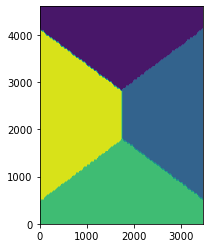

In [5]:
from scipy.spatial.distance import cdist

def associate_point_to_player(image_shape, point):
    image_rows, image_columns = image_shape
    point_row , point_column  = point
    
    player_points = [(image_rows, image_columns / 2), (image_rows / 2, image_columns), (0, image_columns / 2), (image_rows / 2, 0)]
    
    distances = cdist(player_points, [point])
    
    player = np.argmin(distances) + 1
    
    return player


n_rows, n_cols, _ = image.shape
rows_list = np.linspace(0, n_rows-1, 100)
cols_list = np.linspace(0, n_cols-1, 100)
rows_mesh, cols_mesh = np.meshgrid(rows_list, cols_list)

res = [associate_point_to_player((n_rows, n_cols), (p1, p2)) for p1, p2 in zip(rows_mesh.ravel(), cols_mesh.ravel())]
res = np.reshape(res, rows_mesh.shape)

plt.contourf(cols_mesh, rows_mesh, res)
plt.gca().set_aspect('equal')

In [6]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

In [81]:
# global widht_height_list
# width_height_list = []


class Extractor():
    
    def __init__(self, canny_thresholds = (25, 100), hough_circles_parameters = (50, 30), sigma_gaussian_blur = 5,
                 smaller_card_side_range = (400, 700), larger_card_size_range = (600, 900), 
                 nms_threshold = 0.3, tolerance = 30, min_size = 2000, median_filter_size = 5):
        """
        tolerance::[float]
            Tolerance in inequality check to decide whether components are close enough.
        min_size::[int]
                Minimum size in number of pixels of component to be considered a valid object.
        """
        
        # Parameters used to extract dealer circle.
        self.hough_circles_parameters = hough_circles_parameters
        
        # Parameters used to extract cards.
        self.canny_thresholds = canny_thresholds
        self.sigma_gaussian_blur = sigma_gaussian_blur
        self.smaller_card_side_range = (min(smaller_card_side_range), max(smaller_card_side_range))
        self.larger_card_size_range  = (min(larger_card_size_range ), max(larger_card_size_range ))
        self.nms_threshold = nms_threshold
        
        # Parameters used to extract figures and suits.
        self.tolerance = tolerance
        self.min_size  = min_size
        self.median_filter_size = median_filter_size
        
        
    def __call__(self, image):
        return self._extract(image) 
        
        
    def _extract(self, image):
        dealer_circle, dealer_player = self._extract_dealer(image)
        
        cards = self._extract_cards(image, dealer_circle)
                
        figures_suits = self._extract_figures_suits(cards)
        
        return dealer_player, cards, figures_suits
        
        
        
    def _extract_dealer(self, image):
        green_mask  = get_color_pixels(image, "green")

        # Extract circle.
        circles = cv2.HoughCircles(green_mask, cv2.HOUGH_GRADIENT, dp = 1,
                                   minDist = np.inf, 
                                   param1  = self.hough_circles_parameters[0], 
                                   param2  = self.hough_circles_parameters[1])

        circles = np.uint16(np.around(circles))

        # Take the only circle detected, as we put a high minimum distance.
        column, row, radius = circles[0][0]
        
        # Show detection.
        #plt.imshow(image[row-radius:row+radius,column-radius:column+radius][:,:,::-1])
        #plt.show()
        
        # Determine which player is dealer.
        dealer_player = self._associate_point_to_player(image, (row, column))
        
        return (column, row, radius), dealer_player
        
    
    def _extract_cards(self, image, dealer_circle):
        column, row, radius = dealer_circle
        
        gradient = cv2.Canny(image, *self.canny_thresholds) 

        gradient_no_circle         = cv2.circle(gradient, (column, row), int(radius * 1.1), (0, 0, 0), cv2.FILLED)
        gradient_no_circle_blurred = cv2.GaussianBlur(gradient_no_circle, None, sigmaX = self.sigma_gaussian_blur)
        
        contours, _ = cv2.findContours(gradient_no_circle_blurred, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        
        bounding_boxes      = []
        min_area_rectangles = []
        for contour in contours:
            bbox = cv2.boundingRect(contour)
            rect = cv2.minAreaRect (contour)
            
            if self._bbox_can_be_card(bbox):
                min_area_rectangles.append(rect)
                bounding_boxes     .append(bbox)
        
        indices = cv2.dnn.NMSBoxes(bounding_boxes, [w*h for _, _, w, h in bounding_boxes], 0, self.nms_threshold)
        bounding_boxes      = [bbox for idx, bbox in enumerate(bounding_boxes     ) if idx in indices]
        min_area_rectangles = [rect for idx, rect in enumerate(min_area_rectangles) if idx in indices]

        cards = {}
        for bbox, rect in zip(bounding_boxes, min_area_rectangles):
            player = self._associate_bbox_to_player(image, bbox)
            
            # Rotate and Crop Min Area Rectangle.
            
            
            def _crop_min_area_rect(image, rect):          
                # the order of the box points: bottom left, top left, top right,
                # bottom right
                
                original_points = np.int0(cv2.boxPoints(rect)).astype(np.float32)

                # get width and height of the detected rectangle
                _, (width, height), _ = rect
                width, height = int(width), int(height)

                # coordinate of the points in box points after the rectangle has been
                # straightened                
                destination_points = np.array([[0, height-1],
                                               [0, 0],
                                               [width-1, 0],
                                               [width-1, height-1]], dtype="float32")

                # the perspective transformation matrix
                M = cv2.getPerspectiveTransform(original_points, destination_points)

                # directly warp the rotated rectangle to get the straightened rectangle
                warped = cv2.warpPerspective(image, M, (width, height))
                
                return warped
                
            
            print('Player:', player, 'Angle:', rect[-1])
            
            rect = adjust_angle(rect, player)
            
            print('Player:', player, 'Angle:', rect[-1])

            card_image = _crop_min_area_rect(image, rect)
            
            cards[player] = card_image
        
        return cards
        
    
    
    def _bbox_can_be_card(self, bbox):
        _, _, width, height = bbox
        
        # Debug only ---------
#         width_height_list.append(width)
#         width_height_list.append(height)
        # --------------------
        
        width_in_smaller_range = self.smaller_card_side_range[0] <= width <= self.smaller_card_side_range[1]
        width_in_larger_range  = self.larger_card_size_range [0] <= width <= self.larger_card_size_range [1]

        height_in_smaller_range = self.smaller_card_side_range[0] <= height <= self.smaller_card_side_range[1]
        height_in_larger_range  = self.larger_card_size_range [0] <= height <= self.larger_card_size_range [1]
        
        return (width_in_smaller_range and height_in_larger_range) or (width_in_larger_range and height_in_smaller_range)
    
    def _estimate_center_figure_suits(self, figure_not_suits = True):
        shape_of_square = None
    
    
    
    def _associate_point_to_player(self, image, point):       
        image_rows, image_columns = image.shape[0], image.shape[1]
        point_row , point_column  = point

        player_points = [(image_rows, image_columns / 2), (image_rows / 2, image_columns), (0, image_columns / 2), (image_rows / 2, 0)]

        distances = cdist(player_points, [point])

        player = np.argmin(distances) + 1

        return player
    
    
    def _associate_bbox_to_player(self, image, bbox):
        column, row, width, height = bbox
        center_row    = row    + height / 2
        center_column = column + width  / 2

        return self._associate_point_to_player(image, (center_row, center_column))
    
    
    def _extract_figures_suits(self, cards):
        figures_suits = {}
        
        for player, card in cards.items():
            
            # Maybe do illumination equalization? Didn't work when I tried 
            
            red_mask   = get_color_pixels(card, "red")
            black_mask = get_color_pixels(card, "black")
                        
            mask = red_mask if red_mask.sum() > black_mask.sum() else black_mask
            
            mask = cv2.medianBlur(mask, self.median_filter_size)
            _, new_mask = self._get_objects_from_mask(mask)
            
            
            
            
            
            r, c = new_mask.shape
            X = np.transpose(np.where(new_mask))
            centroids_init = np.multiply([[0., 0.], [0.5, 0.5], [1., 1.]], new_mask.shape)
            kmeans = KMeans(n_clusters = 3, init = centroids_init, n_init = 1).fit(X)
            
            cards[player] = np.ascontiguousarray(cards[player], dtype = np.uint8)
            center, size = np.array(kmeans.cluster_centers_[0][::-1]).astype(np.int), 70
            cv2.rectangle(cards[player], center - size, center + size, color = (0,255,0), thickness = 3)
            center, size = np.array(kmeans.cluster_centers_[1][::-1]).astype(np.int), 150
            cv2.rectangle(cards[player], center - size, center + size, color = (0,255,0), thickness = 3)            
            center, size = np.array(kmeans.cluster_centers_[2][::-1]).astype(np.int), 70
            cv2.rectangle(cards[player], center - size, center + size, color = (0,255,0), thickness = 3)
            
            
            figure_symbol = suit_symbol = [[0]]
            
            figures_suits[player] = {"figure": figure_symbol, "suit": suit_symbol}   
            
        return figures_suits
            
    def _detect_same_object(self, component1, component2):
        """
        Function returning whether two components are sufficiently close to be classified as belonging
        to same object. 

        Args:
            component1::[dict]
                Dictionary of form {"centroid": np.array, "width": float, "height": float} containing
                information about the first connected component.
            component2::[dict]
                Dictionary of form {"centroid": np.array, "width": float, "height": float} containing
                information about the second connected component.        
        Returns:
            output::[boolean]
                True if the components are close enough to probably be part of the same object, False
                otherwise.
        """
        distance = np.linalg.norm(component1["centroid"] - component2["centroid"])
        radius_component1 = (component1["width"] + component1["height"]) / 4 
        radius_component2 = (component2["width"] + component2["height"]) / 4 

        return distance <= radius_component1 + self.tolerance or distance <= radius_component2 + self.tolerance


    def _get_objects_from_mask(self, mask):
        """
        Function returning segmentation mask of objects obtained by cleaning the color mask passed
        as parameter. 

        Args:
            mask::[np.array]
                Image mask obtained by color thresholding.
        Returns:
            objects_mask::[np.array]
                Mask of same size as input mask segmenting the objects which are large enough and
                grouped into one object if they are close enough.
        """
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)

        # Merging close components that belong to same object, skipping background labeled 0.
        new_labels = {}
        for component1 in range(1, num_labels):
            parameters1 = {"centroid": np.array(centroids[component1]), "width": stats[component1, cv2.CC_STAT_WIDTH], "height": stats[component1, cv2.CC_STAT_HEIGHT]}
            for component2 in range(component1 + 1, num_labels):
                parameters2 = {"centroid": np.array(centroids[component2]), "width": stats[component2, cv2.CC_STAT_WIDTH], "height": stats[component2, cv2.CC_STAT_HEIGHT]}
                if self._detect_same_object(parameters1, parameters2):
                    new_labels[component2] = component1

        # Solves conflicts caused by values in dictionary which are also keys.
        key_value_conflicts = [key for key, value in new_labels.items() if value in new_labels.keys()]
        while key_value_conflicts:
            for conflict in key_value_conflicts:
                new_labels[conflict] = new_labels[new_labels[conflict]]
            key_value_conflicts = [key for key, value in new_labels.items() if value in new_labels.keys()]

        # Merges close components that belong to same object.
        for old_component, new_component in new_labels.items():
            labels[labels == old_component] = new_component

        # Removes too small groups (merges them with background).
        unique, counts = np.unique(labels, return_counts=True)
        for component, n_pixels in zip(unique, counts):
            if n_pixels < self.min_size:
                labels[labels == component] = 0
            else:
                continue
                print("N. pixels component: ", n_pixels)

        # -1 for the background
        return len(np.unique(labels)) -1 , labels
                
        
        # Creates mask from components not in background.
        objects_mask = labels > 0

        return len(np.unique(labels[objects_mask])), labels

In [82]:
data_loader = DataLoader()
extractor = Extractor()

In [108]:
def adjust_angle(rect, player):
    center, (width, height), angle = rect
    
    if player == 1:
        if angle == 90:
            return center, (height, width), 0
        
        if height < width:
            return center, (height, width), angle - 90


    return rect

Game: 1, Round: 1
Player: 1 Angle: 90.0
Player: 1 Angle: 0
Player: 4 Angle: 2.550464630126953
Player: 4 Angle: 2.550464630126953
Player: 2 Angle: 88.74095153808594
Player: 2 Angle: 88.74095153808594
Player: 3 Angle: 2.1926865577697754
Player: 3 Angle: 2.1926865577697754


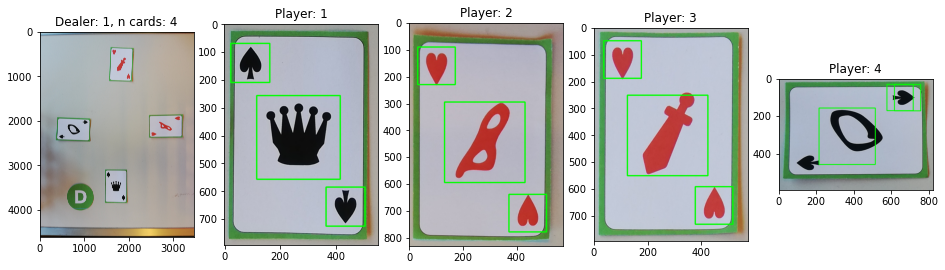

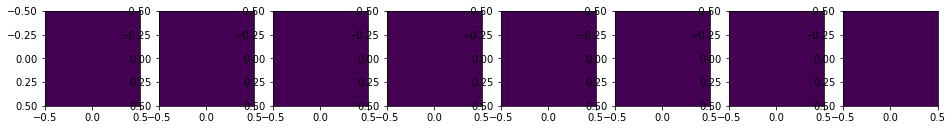

Game: 1, Round: 2
Player: 1 Angle: 84.67066192626953
Player: 1 Angle: -5.329338073730469
Player: 4 Angle: 1.2730300426483154
Player: 4 Angle: 1.2730300426483154
Player: 2 Angle: 87.49837493896484
Player: 2 Angle: 87.49837493896484
Player: 3 Angle: 88.35755920410156
Player: 3 Angle: 88.35755920410156


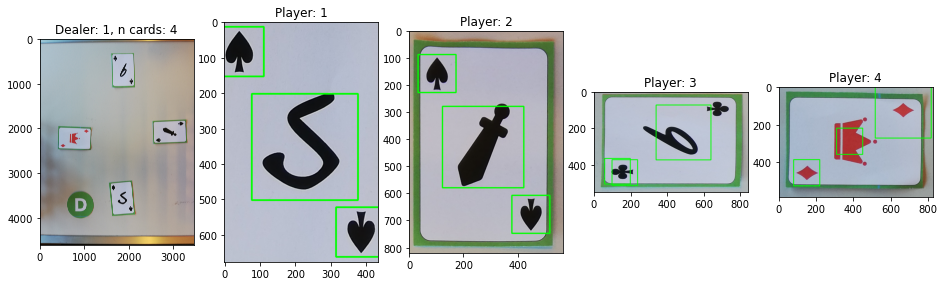

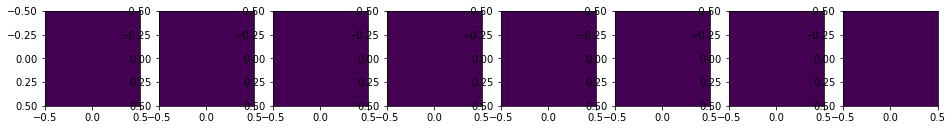

Game: 1, Round: 3
Player: 1 Angle: 85.75820922851562
Player: 1 Angle: -4.241790771484375
Player: 4 Angle: 88.76002502441406
Player: 4 Angle: 88.76002502441406
Player: 2 Angle: 11.639690399169922
Player: 2 Angle: 11.639690399169922
Player: 3 Angle: 89.36103820800781
Player: 3 Angle: 89.36103820800781


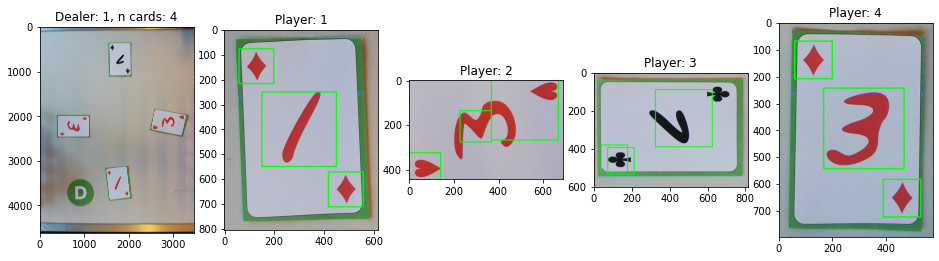

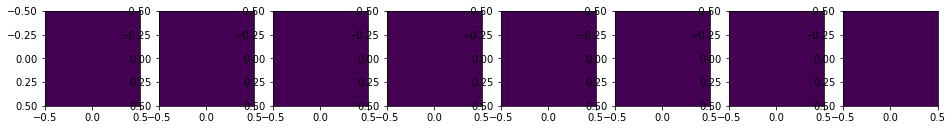

Game: 1, Round: 4
Player: 1 Angle: 89.62139892578125
Player: 1 Angle: -0.37860107421875
Player: 4 Angle: 5.314545154571533
Player: 4 Angle: 5.314545154571533
Player: 2 Angle: 88.57502746582031
Player: 2 Angle: 88.57502746582031
Player: 3 Angle: 3.653872013092041
Player: 3 Angle: 3.653872013092041


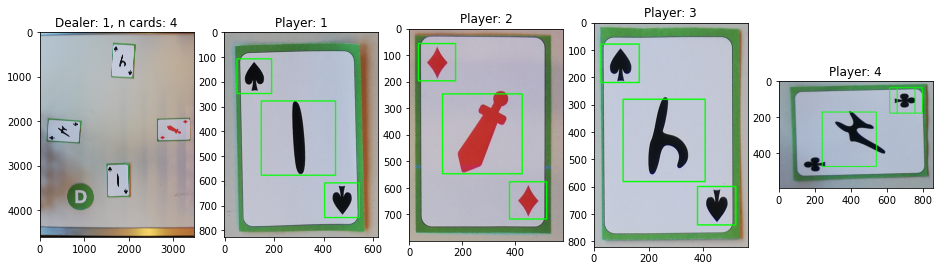

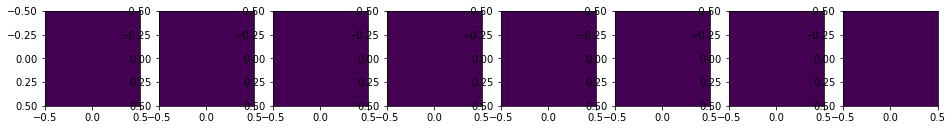

Game: 1, Round: 5
Player: 1 Angle: 83.84191131591797
Player: 1 Angle: -6.158088684082031
Player: 2 Angle: 5.500411033630371
Player: 2 Angle: 5.500411033630371
Player: 4 Angle: 86.7674560546875
Player: 4 Angle: 86.7674560546875
Player: 3 Angle: 89.90962219238281
Player: 3 Angle: 89.90962219238281


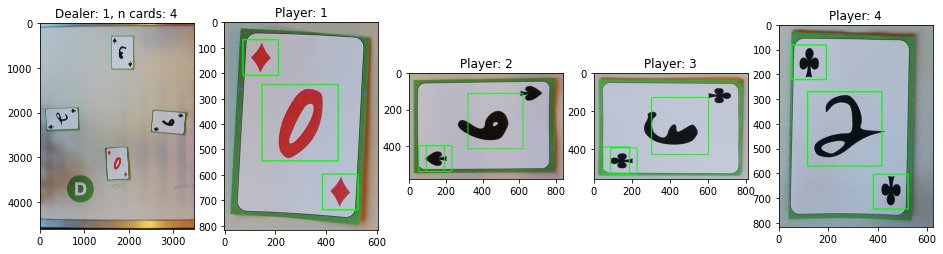

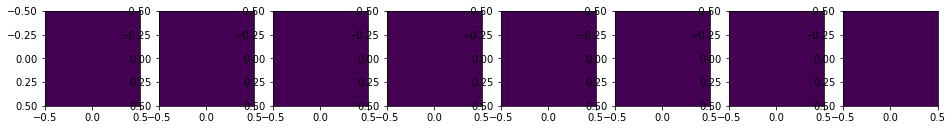

Game: 1, Round: 6
Player: 1 Angle: 1.1108592748641968
Player: 1 Angle: 1.1108592748641968
Player: 2 Angle: 2.2679543495178223
Player: 2 Angle: 2.2679543495178223
Player: 4 Angle: 85.97368621826172
Player: 4 Angle: 85.97368621826172
Player: 3 Angle: 3.416588068008423
Player: 3 Angle: 3.416588068008423


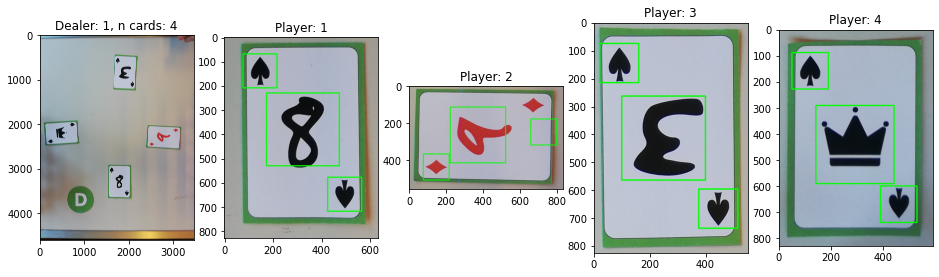

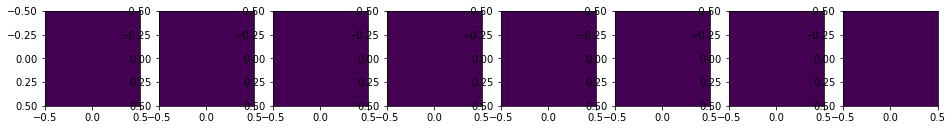

Game: 1, Round: 7
Player: 1 Angle: 89.16307067871094
Player: 1 Angle: -0.8369293212890625
Player: 2 Angle: 89.51853942871094
Player: 2 Angle: 89.51853942871094
Player: 4 Angle: 0.8550973534584045
Player: 4 Angle: 0.8550973534584045
Player: 3 Angle: 0.8231586813926697
Player: 3 Angle: 0.8231586813926697


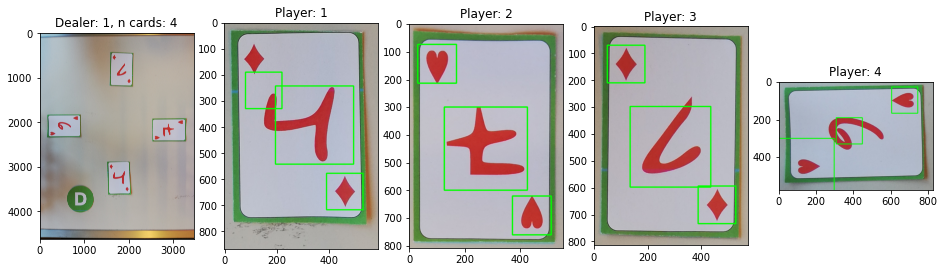

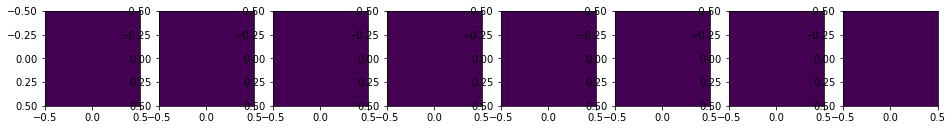

Game: 1, Round: 8
Player: 1 Angle: 0.2923228442668915
Player: 1 Angle: 0.2923228442668915
Player: 4 Angle: 2.8933539390563965
Player: 4 Angle: 2.8933539390563965
Player: 2 Angle: 0.7252243161201477
Player: 2 Angle: 0.7252243161201477
Player: 3 Angle: 88.36341857910156
Player: 3 Angle: 88.36341857910156


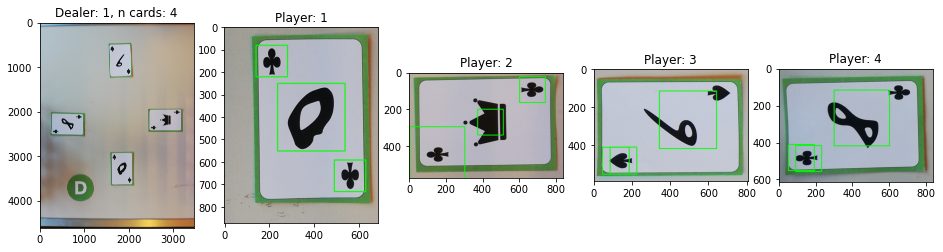

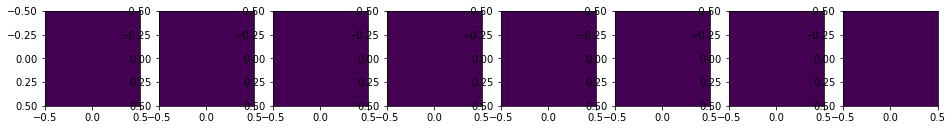

Game: 1, Round: 9
Player: 1 Angle: 0.8251908421516418
Player: 1 Angle: 0.8251908421516418
Player: 4 Angle: 1.3296438455581665
Player: 4 Angle: 1.3296438455581665
Player: 2 Angle: 0.17231760919094086
Player: 2 Angle: 0.17231760919094086
Player: 3 Angle: 89.33251190185547
Player: 3 Angle: 89.33251190185547


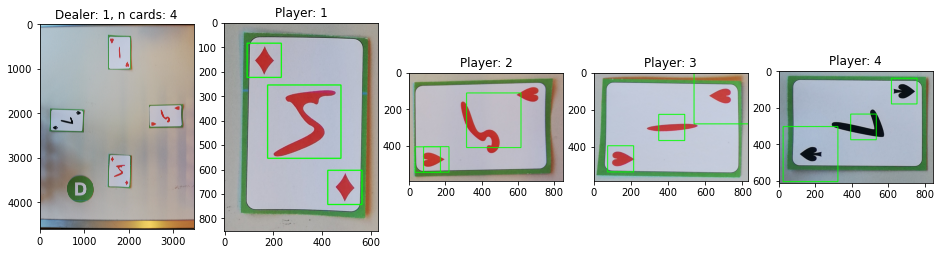

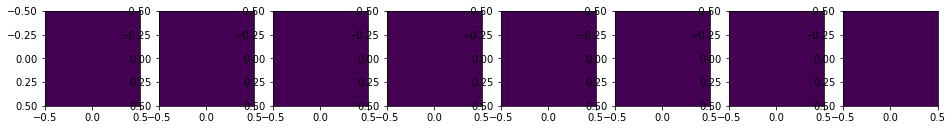

Game: 1, Round: 10
Player: 1 Angle: 86.58341979980469
Player: 1 Angle: -3.4165802001953125
Player: 4 Angle: 77.9432373046875
Player: 4 Angle: 77.9432373046875
Player: 2 Angle: 87.10873413085938
Player: 2 Angle: 87.10873413085938
Player: 3 Angle: 81.32091522216797
Player: 3 Angle: 81.32091522216797


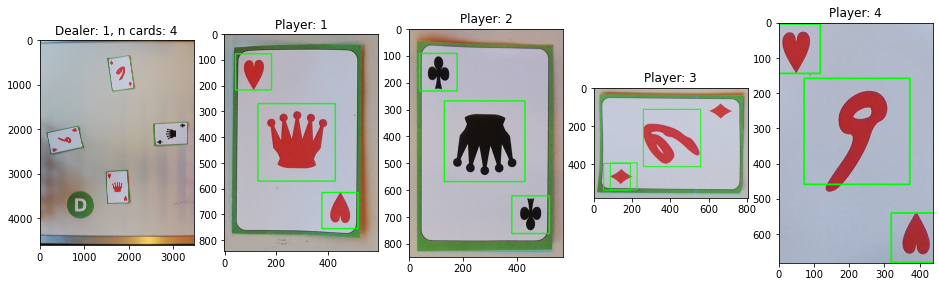

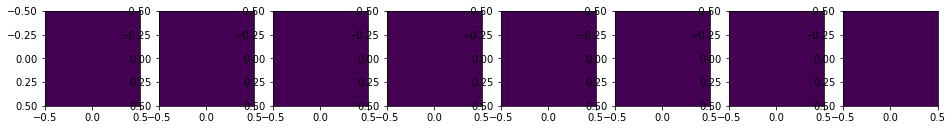

Game: 1, Round: 11
Player: 1 Angle: 6.050236225128174
Player: 1 Angle: 6.050236225128174
Player: 4 Angle: 5.114013195037842
Player: 4 Angle: 5.114013195037842
Player: 2 Angle: 89.83296203613281
Player: 2 Angle: 89.83296203613281
Player: 3 Angle: 0.7742201685905457
Player: 3 Angle: 0.7742201685905457


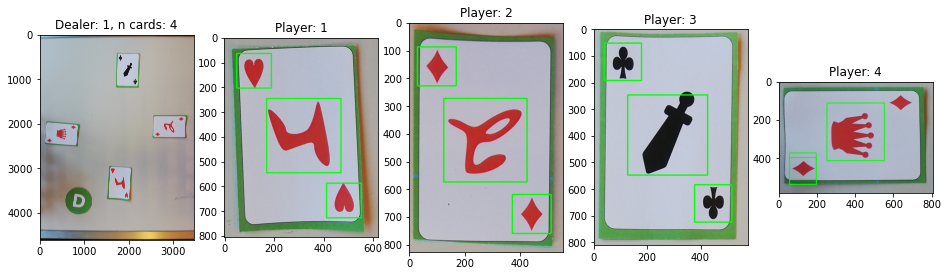

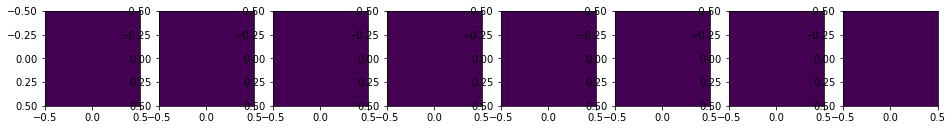

Game: 1, Round: 12
Player: 1 Angle: 2.718477249145508
Player: 1 Angle: 2.718477249145508
Player: 4 Angle: 4.051010608673096
Player: 4 Angle: 4.051010608673096
Player: 2 Angle: 1.4594495296478271
Player: 2 Angle: 1.4594495296478271
Player: 3 Angle: 1.1201658248901367
Player: 3 Angle: 1.1201658248901367


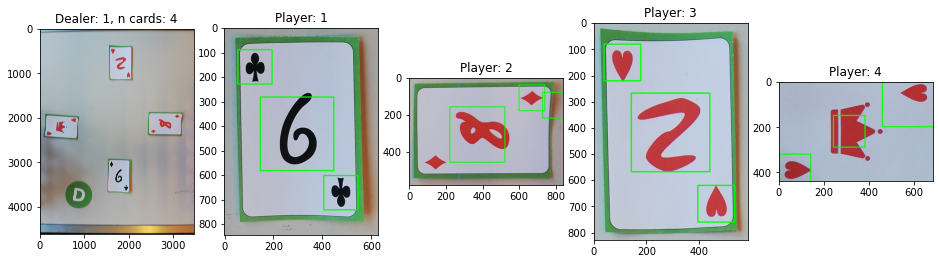

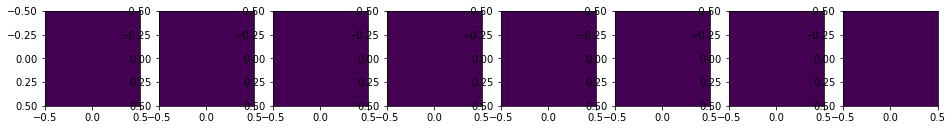

Game: 1, Round: 13
Player: 1 Angle: 2.9593446254730225
Player: 1 Angle: 2.9593446254730225
Player: 2 Angle: 86.63970184326172
Player: 2 Angle: 86.63970184326172
Player: 4 Angle: 6.088528156280518
Player: 4 Angle: 6.088528156280518
Player: 3 Angle: 3.9135332107543945
Player: 3 Angle: 3.9135332107543945


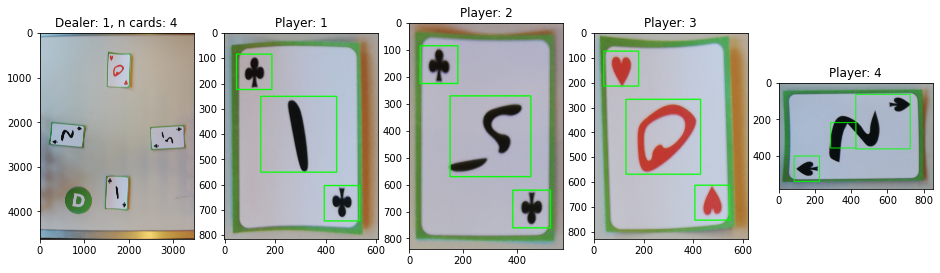

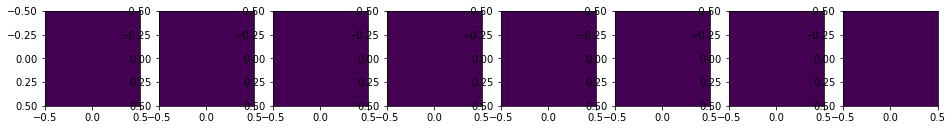

Game: 2, Round: 1
Player: 1 Angle: 4.549758434295654
Player: 1 Angle: 4.549758434295654
Player: 4 Angle: 88.04193115234375
Player: 4 Angle: 88.04193115234375
Player: 2 Angle: 89.08334350585938
Player: 2 Angle: 89.08334350585938
Player: 3 Angle: 0.7139291763305664
Player: 3 Angle: 0.7139291763305664


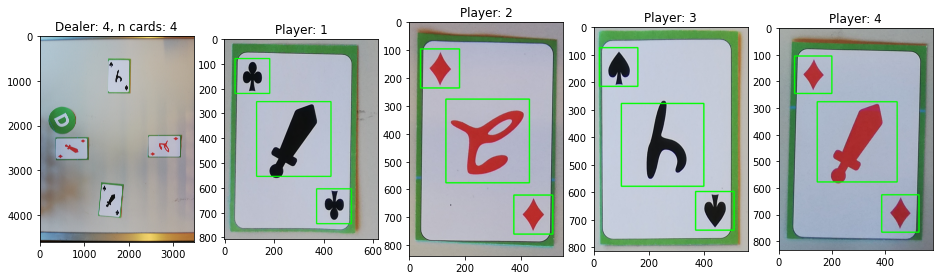

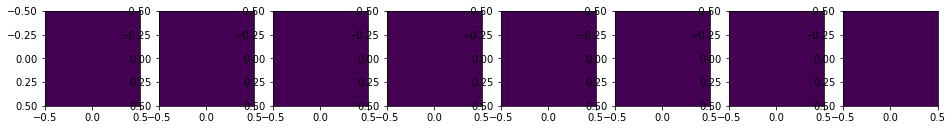

Game: 2, Round: 2
Player: 1 Angle: 1.5565674304962158
Player: 1 Angle: 1.5565674304962158
Player: 4 Angle: 87.97010803222656
Player: 4 Angle: 87.97010803222656
Player: 2 Angle: 0.1028648391366005
Player: 2 Angle: 0.1028648391366005
Player: 3 Angle: 88.48401641845703
Player: 3 Angle: 88.48401641845703


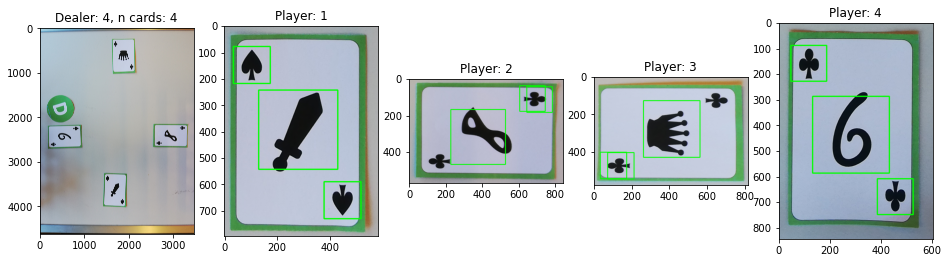

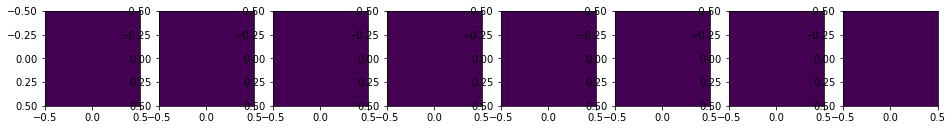

Game: 2, Round: 3
Player: 1 Angle: 0.6427142024040222
Player: 1 Angle: 0.6427142024040222
Player: 4 Angle: 1.4057493209838867
Player: 4 Angle: 1.4057493209838867
Player: 2 Angle: 2.5670974254608154
Player: 2 Angle: 2.5670974254608154
Player: 3 Angle: 89.6834487915039
Player: 3 Angle: 89.6834487915039


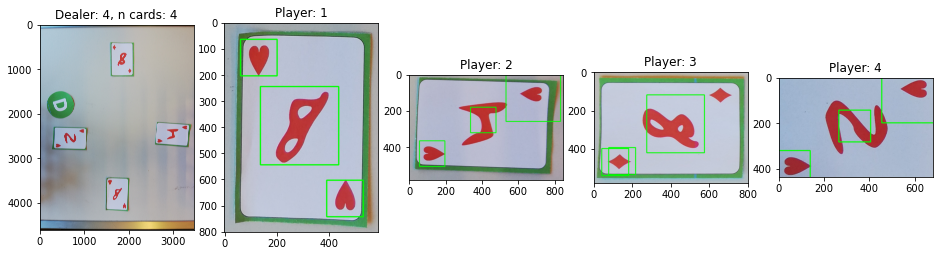

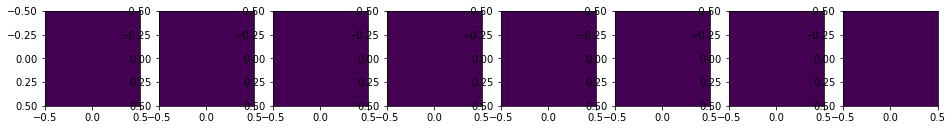

Game: 2, Round: 4
Player: 1 Angle: 3.327404022216797
Player: 1 Angle: 3.327404022216797
Player: 4 Angle: 81.34954071044922
Player: 4 Angle: 81.34954071044922
Player: 2 Angle: 87.99364471435547
Player: 2 Angle: 87.99364471435547
Player: 3 Angle: 3.870349407196045
Player: 3 Angle: 3.870349407196045


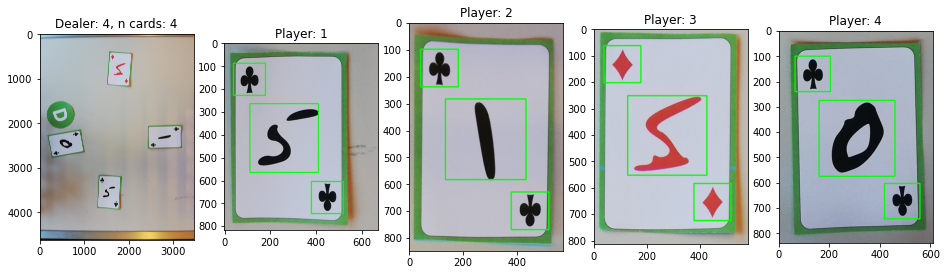

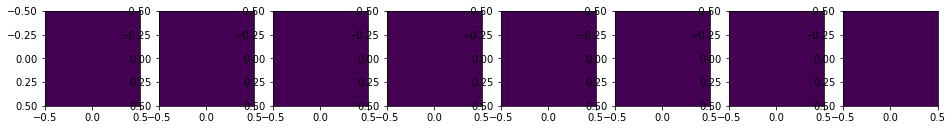

Game: 2, Round: 5
Player: 1 Angle: 0.8599095940589905
Player: 1 Angle: 0.8599095940589905
Player: 2 Angle: 87.86963653564453
Player: 2 Angle: 87.86963653564453
Player: 4 Angle: 2.678011894226074
Player: 4 Angle: 2.678011894226074
Player: 3 Angle: 2.067103385925293
Player: 3 Angle: 2.067103385925293


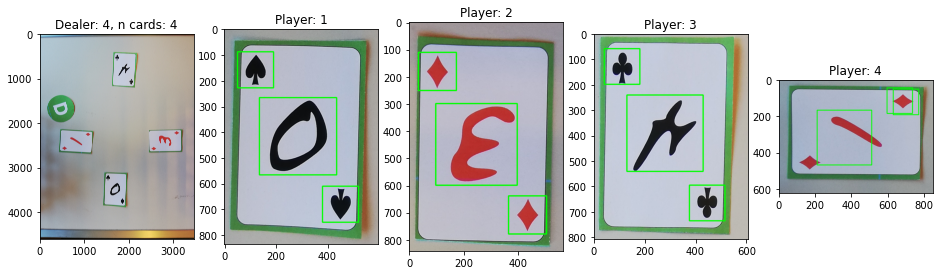

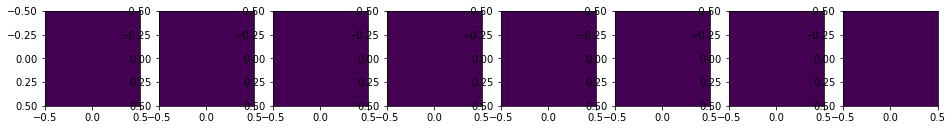

Game: 2, Round: 6
Player: 1 Angle: 79.8121109008789
Player: 1 Angle: -10.187889099121094
Player: 4 Angle: 85.60128784179688
Player: 4 Angle: 85.60128784179688
Player: 2 Angle: 1.0498052835464478
Player: 2 Angle: 1.0498052835464478
Player: 3 Angle: 86.62410736083984
Player: 3 Angle: 86.62410736083984


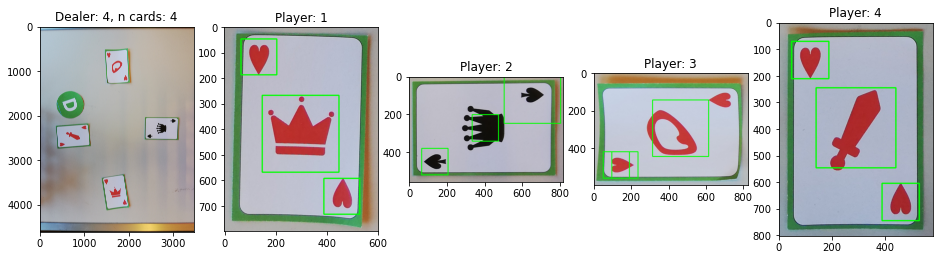

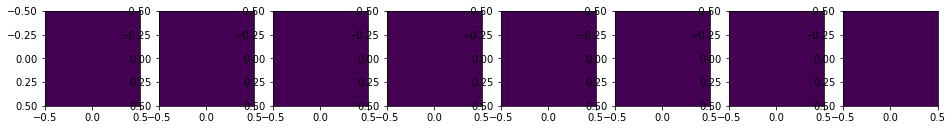

Game: 2, Round: 7
Player: 1 Angle: 87.69522094726562
Player: 1 Angle: -2.304779052734375
Player: 4 Angle: 88.01529693603516
Player: 4 Angle: 88.01529693603516
Player: 2 Angle: 2.990344762802124
Player: 2 Angle: 2.990344762802124
Player: 3 Angle: 88.5627670288086
Player: 3 Angle: 88.5627670288086


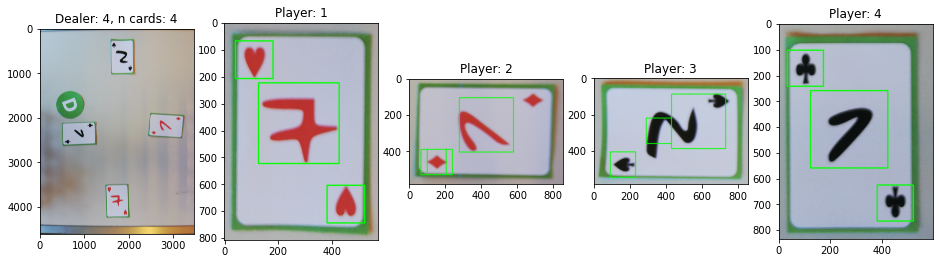

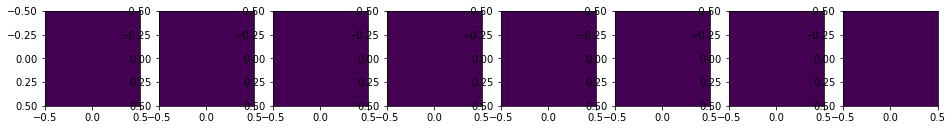

Game: 2, Round: 8
Player: 1 Angle: 82.52645874023438
Player: 1 Angle: -7.473541259765625
Player: 4 Angle: 84.95993041992188
Player: 4 Angle: 84.95993041992188
Player: 2 Angle: 84.89351654052734
Player: 2 Angle: 84.89351654052734
Player: 3 Angle: 4.31927490234375
Player: 3 Angle: 4.31927490234375


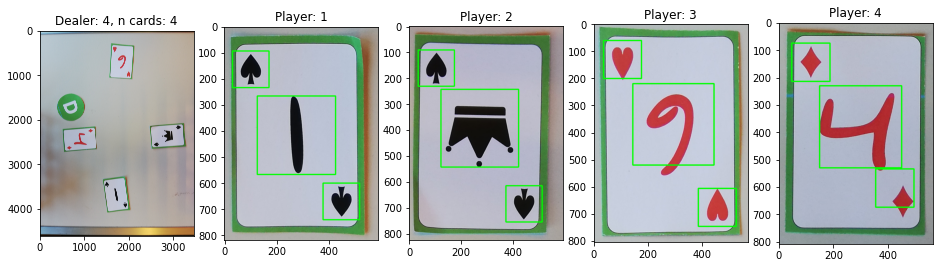

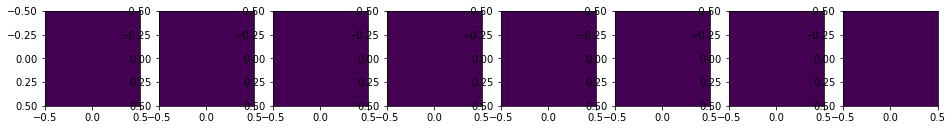

Game: 2, Round: 9
Player: 1 Angle: 83.8533706665039
Player: 1 Angle: -6.146629333496094
Player: 4 Angle: 4.136384010314941
Player: 4 Angle: 4.136384010314941
Player: 2 Angle: 1.2319773435592651
Player: 2 Angle: 1.2319773435592651
Player: 3 Angle: 86.14066314697266
Player: 3 Angle: 86.14066314697266


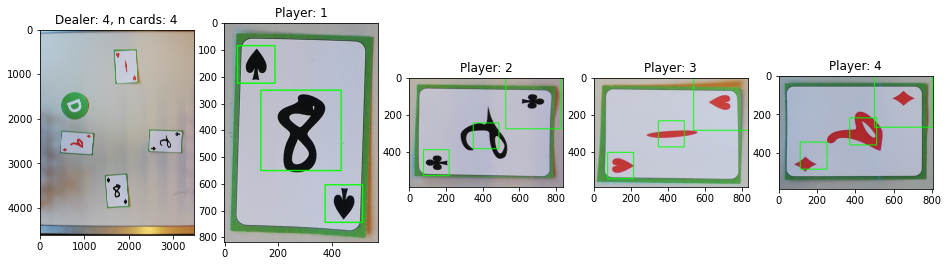

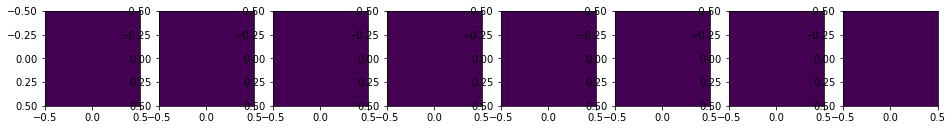

Game: 2, Round: 10
Player: 1 Angle: 88.1603012084961
Player: 1 Angle: -1.8396987915039062
Player: 4 Angle: 6.213375091552734
Player: 4 Angle: 6.213375091552734
Player: 2 Angle: 0.7538482546806335
Player: 2 Angle: 0.7538482546806335
Player: 3 Angle: 5.382428169250488
Player: 3 Angle: 5.382428169250488


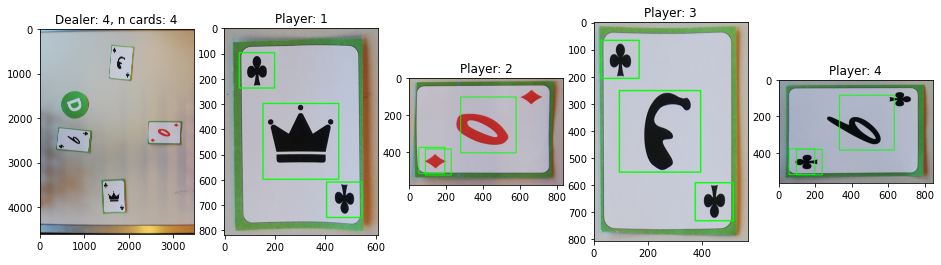

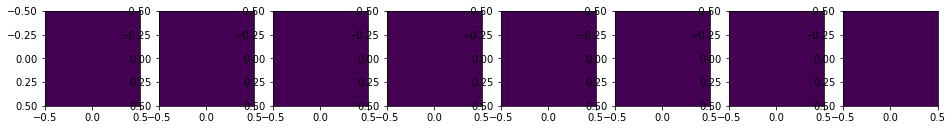

Game: 2, Round: 11
Player: 1 Angle: 88.77367401123047
Player: 1 Angle: -1.2263259887695312
Player: 4 Angle: 2.3090627193450928
Player: 4 Angle: 2.3090627193450928
Player: 2 Angle: 87.86370086669922
Player: 2 Angle: 87.86370086669922
Player: 3 Angle: 3.3548784255981445
Player: 3 Angle: 3.3548784255981445


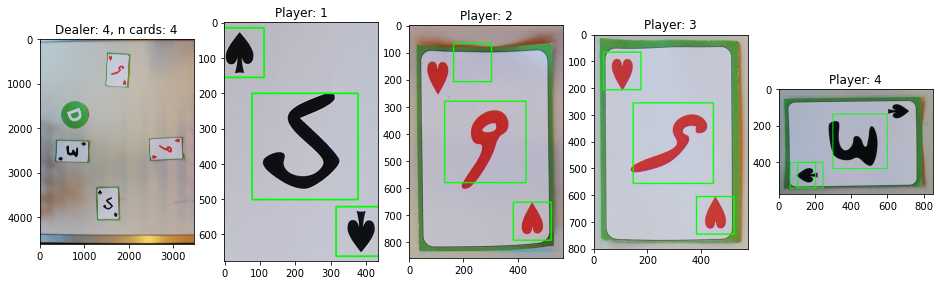

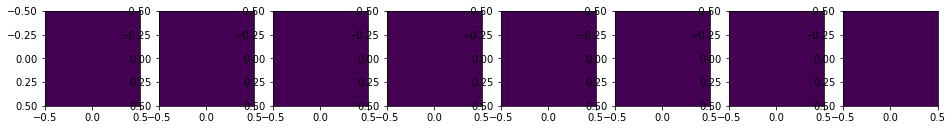

Game: 2, Round: 12
Player: 1 Angle: 7.310226917266846
Player: 1 Angle: 7.310226917266846
Player: 2 Angle: 9.216348648071289
Player: 2 Angle: 9.216348648071289
Player: 4 Angle: 88.22395324707031
Player: 4 Angle: 88.22395324707031
Player: 3 Angle: 1.4191995859146118
Player: 3 Angle: 1.4191995859146118


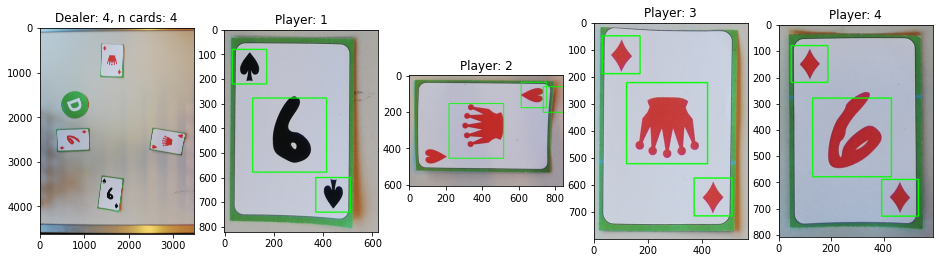

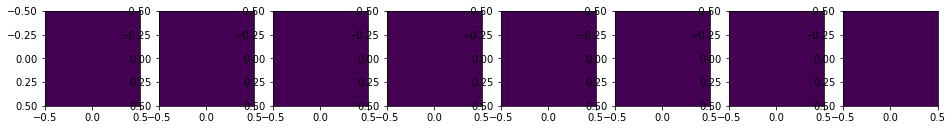

Game: 2, Round: 13
Player: 1 Angle: 3.2916784286499023
Player: 1 Angle: 3.2916784286499023
Player: 4 Angle: 3.4737563133239746
Player: 4 Angle: 3.4737563133239746
Player: 2 Angle: 0.09241247177124023
Player: 2 Angle: 0.09241247177124023
Player: 3 Angle: 86.45416259765625
Player: 3 Angle: 86.45416259765625


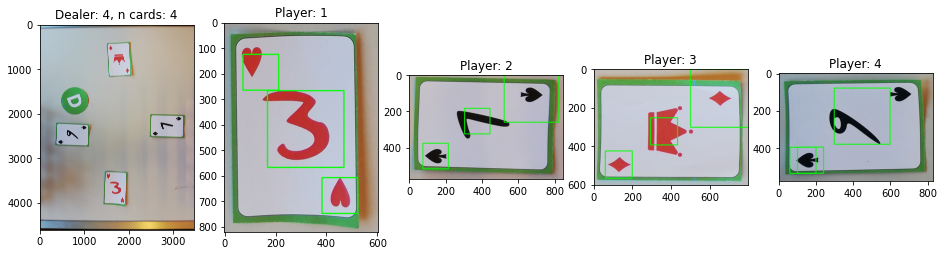

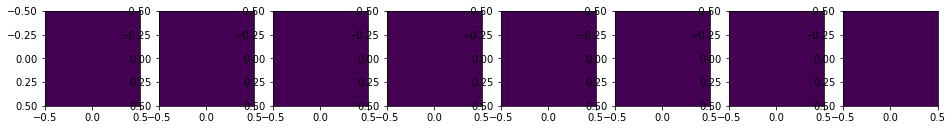

Game: 3, Round: 1
Player: 1 Angle: 0.7025015950202942
Player: 1 Angle: 0.7025015950202942
Player: 2 Angle: 89.80512237548828
Player: 2 Angle: 89.80512237548828
Player: 4 Angle: 87.38045501708984
Player: 4 Angle: 87.38045501708984
Player: 3 Angle: 6.210689067840576
Player: 3 Angle: 6.210689067840576


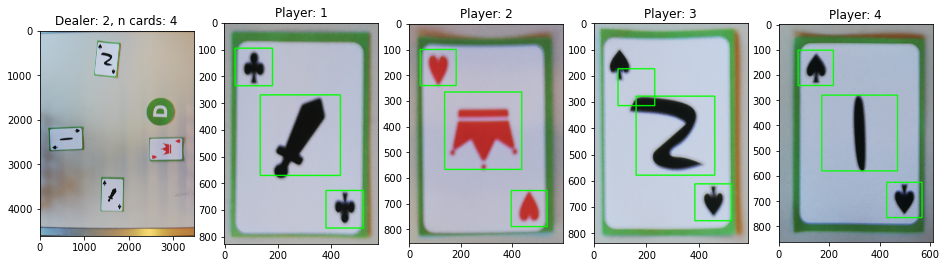

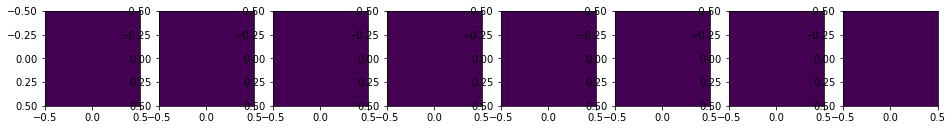

Game: 3, Round: 2
Player: 1 Angle: 1.6211459636688232
Player: 1 Angle: 1.6211459636688232
Player: 2 Angle: 88.06149291992188
Player: 2 Angle: 88.06149291992188
Player: 4 Angle: 90.0
Player: 4 Angle: 90.0
Player: 3 Angle: 2.0551869869232178
Player: 3 Angle: 2.0551869869232178


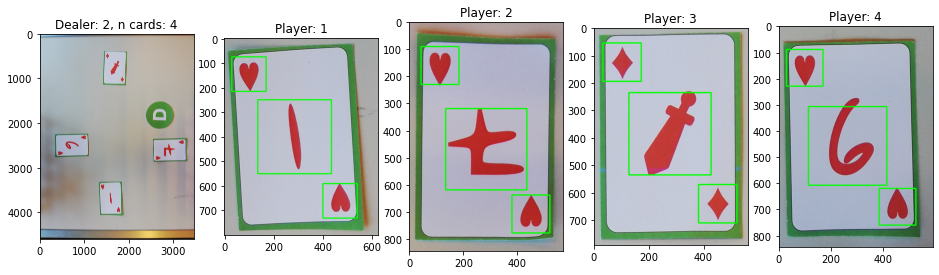

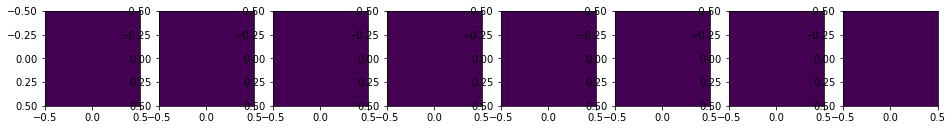

Game: 3, Round: 3
Player: 1 Angle: 86.12459564208984
Player: 1 Angle: -3.8754043579101562
Player: 2 Angle: 3.079399585723877
Player: 2 Angle: 3.079399585723877
Player: 4 Angle: 4.049581527709961
Player: 4 Angle: 4.049581527709961
Player: 3 Angle: 0.7489217519760132
Player: 3 Angle: 0.7489217519760132


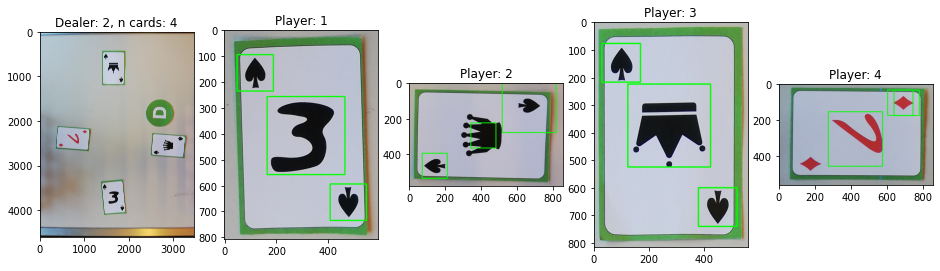

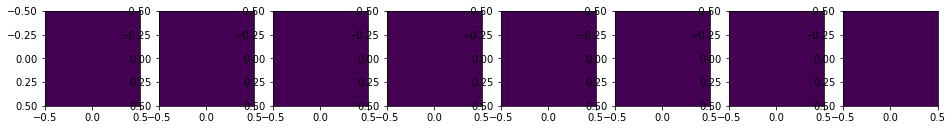

Game: 3, Round: 4
Player: 1 Angle: 88.736328125
Player: 1 Angle: -1.263671875
Player: 2 Angle: 5.678661823272705
Player: 2 Angle: 5.678661823272705
Player: 4 Angle: 11.650299072265625
Player: 4 Angle: 11.650299072265625
Player: 3 Angle: 83.57012176513672
Player: 3 Angle: 83.57012176513672


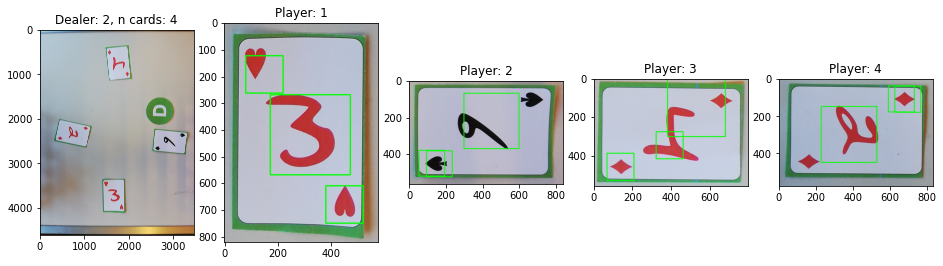

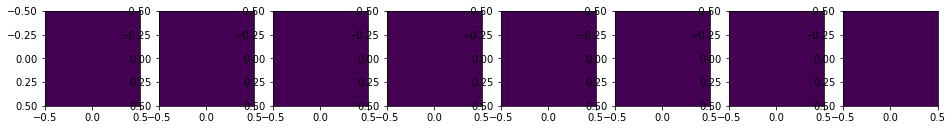

Game: 3, Round: 5
Player: 1 Angle: 83.2843246459961
Player: 1 Angle: -6.715675354003906
Player: 2 Angle: 2.167365074157715
Player: 2 Angle: 2.167365074157715
Player: 4 Angle: 87.87889862060547
Player: 4 Angle: 87.87889862060547
Player: 3 Angle: 83.96794128417969
Player: 3 Angle: 83.96794128417969


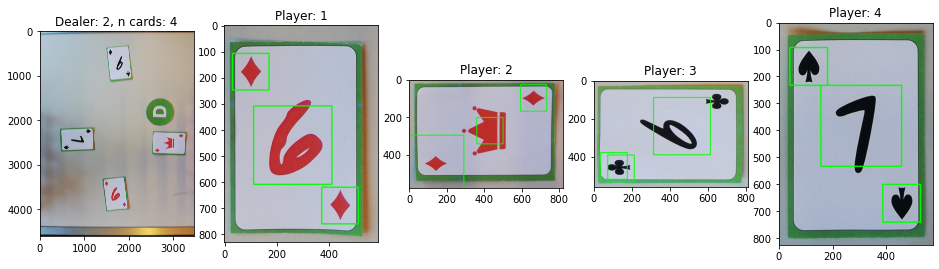

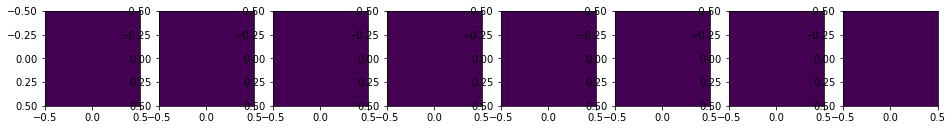

Game: 3, Round: 6
Player: 1 Angle: 78.4300308227539
Player: 1 Angle: -11.569969177246094
Player: 2 Angle: 89.83995056152344
Player: 2 Angle: 89.83995056152344
Player: 4 Angle: 80.91992950439453
Player: 4 Angle: 80.91992950439453
Player: 3 Angle: 86.58341979980469
Player: 3 Angle: 86.58341979980469


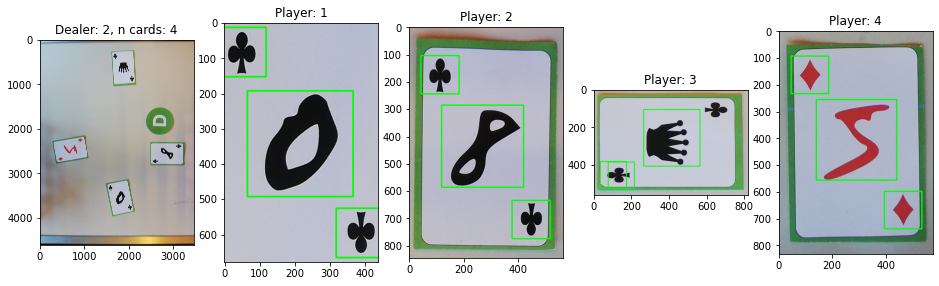

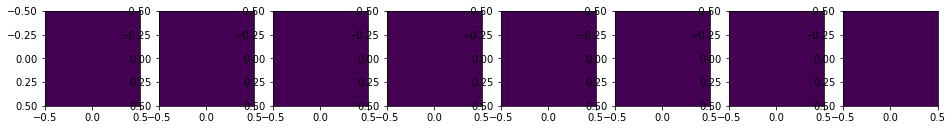

Game: 3, Round: 7
Player: 1 Angle: 85.80233001708984
Player: 1 Angle: -4.197669982910156
Player: 2 Angle: 0.21952298283576965
Player: 2 Angle: 0.21952298283576965
Player: 4 Angle: 0.4188213646411896
Player: 4 Angle: 0.4188213646411896
Player: 3 Angle: 89.01839447021484
Player: 3 Angle: 89.01839447021484


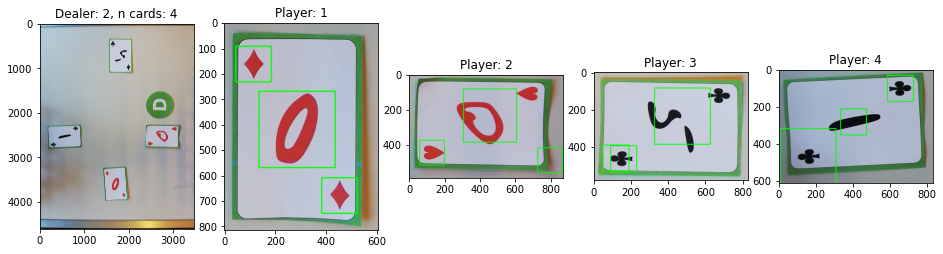

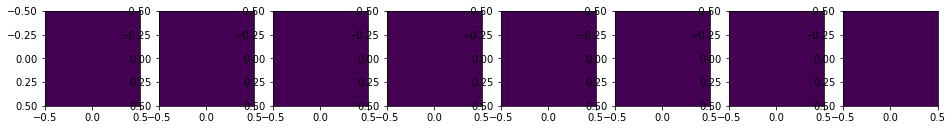

Game: 3, Round: 8
Player: 1 Angle: 2.2183828353881836
Player: 1 Angle: 2.2183828353881836
Player: 2 Angle: 89.29557800292969
Player: 2 Angle: 89.29557800292969
Player: 4 Angle: 88.68719482421875
Player: 4 Angle: 88.68719482421875
Player: 3 Angle: 85.58479309082031
Player: 3 Angle: 85.58479309082031


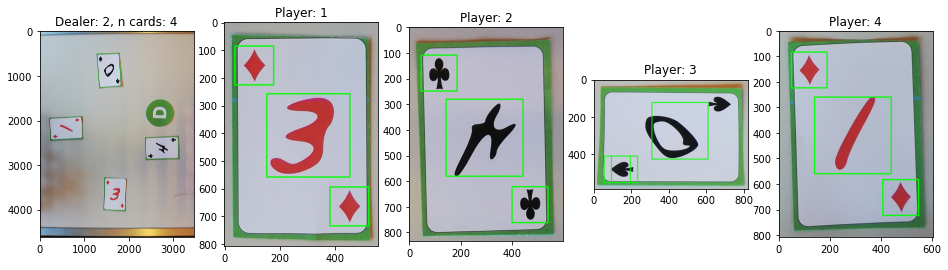

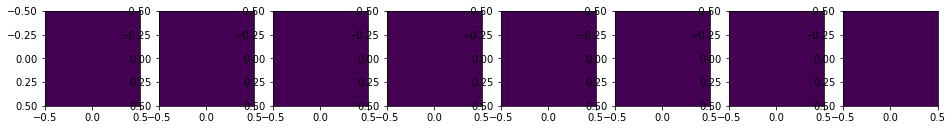

Game: 3, Round: 9
Player: 1 Angle: 6.075832843780518
Player: 1 Angle: 6.075832843780518
Player: 2 Angle: 3.468229293823242
Player: 2 Angle: 3.468229293823242
Player: 4 Angle: 88.87670135498047
Player: 4 Angle: 88.87670135498047
Player: 3 Angle: 2.9337480068206787
Player: 3 Angle: 2.9337480068206787


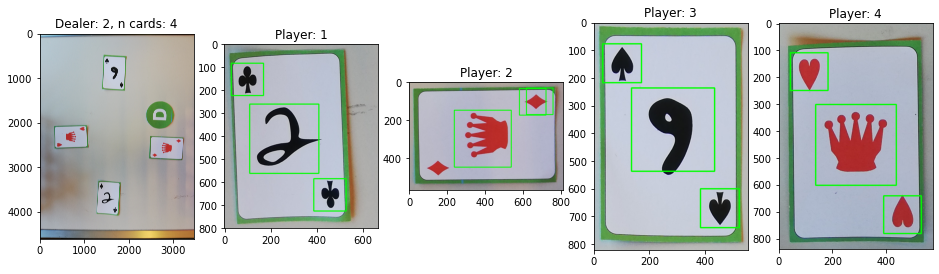

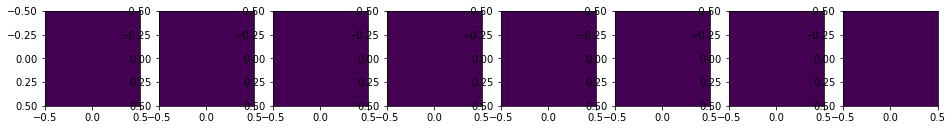

Game: 3, Round: 10
Player: 1 Angle: 82.25064849853516
Player: 1 Angle: -7.749351501464844
Player: 4 Angle: 88.67894744873047
Player: 4 Angle: 88.67894744873047
Player: 2 Angle: 85.80957794189453
Player: 2 Angle: 85.80957794189453
Player: 3 Angle: 85.28648376464844
Player: 3 Angle: 85.28648376464844


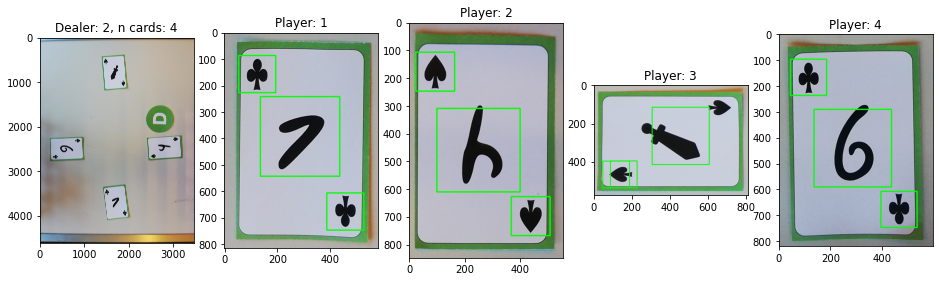

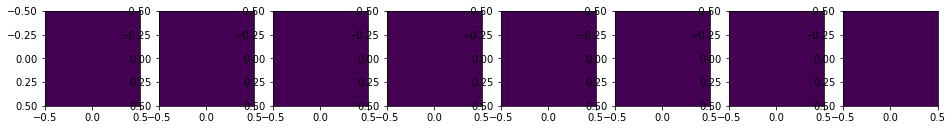

Game: 3, Round: 11


KeyboardInterrupt: 

In [109]:
for game in range(1, 7+1):
    for round_ in range(1, 13+1):
        print("Game: {}, Round: {}".format(game, round_))
        image, _ = data_loader[game, round_]
        dealer, cards, figures_suits = extractor(image)
                
        fig, axes = plt.subplots(1, 5, figsize = (16, 5))
        
        for player, ax in zip(sorted(cards.keys()), axes[1:]):
            ax.set_title("Player: " + str(player))
            ax.imshow(cards[player][:,:,::-1])
        
        axes[0].imshow(image[:,:,::-1])
        axes[0].set_title("Dealer: " + str(dealer) + ", n cards: " + str(len(cards)))
        plt.show()
        
        fig, axes = plt.subplots(1, 8, figsize = (16, 5))

        for i, player in enumerate(sorted(figures_suits.keys())):
            axes[2*i  ].imshow(figures_suits[player]['figure'])
            axes[2*i+1].imshow(figures_suits[player]['suit'])
            
        plt.show()

In [ ]:
plt.hist([elem for elem in width_height_list if elem > 200 and elem < 1000], bins=1000);